### Bayesian Neural Network MNIST Image Recognition

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf
from edward.models import Categorical, Normal
import edward as ed
import pandas as pd

In [2]:
from observations import mnist
(x_train, y_train), (x_test, y_test) = mnist("~/data")
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train = x_train / 255.0
x_test = x_test / 255.0
print(x_train.shape)
print(x_test.shape)

(60000, 784)
(10000, 784)


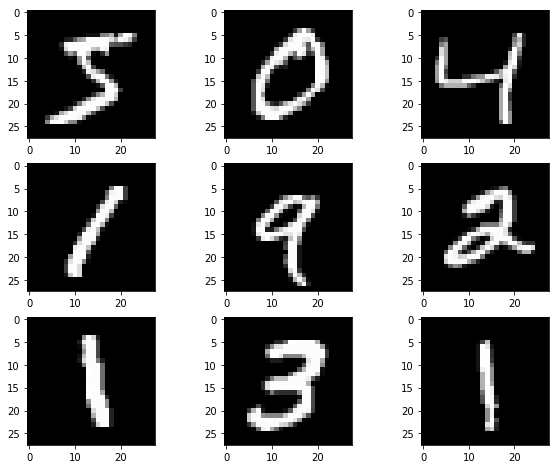

In [3]:
from scipy.misc import toimage
plt.figure(figsize=(10,8))
for i in range(0, 9):
    plt.subplot(330 + 1 + i)
    plt.imshow(x_train[i].reshape((28,28)), cmap='gray')
plt.show()

In [4]:
from keras.utils import to_categorical
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
print(y_train.shape)
print(y_test.shape)

(60000, 10)
(10000, 10)


Using TensorFlow backend.


In [5]:
ed.set_seed(314159)
N = 100   # number of images in a minibatch.
D = 784   # number of features.
K = 10    # number of classes.

# Create a placeholder to hold the data (in minibatches) in a TensorFlow graph.
x = tf.placeholder(tf.float32, [None, D])
# Normal(0,1) priors for the variables. Note that the syntax assumes TensorFlow 1.1.
w = Normal(loc=tf.zeros([D, K]), scale=tf.ones([D, K]))
b = Normal(loc=tf.zeros(K), scale=tf.ones(K))
# Categorical likelihood for classication.
y = Categorical(tf.matmul(x, w) + b)

In [6]:
# Contruct the q(w) and q(b). in this case we assume Normal distributions.
qw = Normal(loc=tf.Variable(tf.random_normal([D, K])),
              scale=tf.nn.softplus(tf.Variable(tf.random_normal([D, K]))))
qb = Normal(loc=tf.Variable(tf.random_normal([K])),
              scale=tf.nn.softplus(tf.Variable(tf.random_normal([K]))))

In [7]:
def generator(arrays, batch_size = N):
    starts = [0] * len(arrays)  # pointers to where we are in iteration
    while True:
        batches = []
        for i, array in enumerate(arrays):
            start = starts[i]
            stop = start + batch_size
            diff = stop - array.shape[0]
            if diff <= 0:
                batch = array[start:stop]
                starts[i] += batch_size
            else:
                batch = np.concatenate((array[start:], array[:diff]))
                starts[i] = diff
            batches.append(batch)
        yield batches
mnist = generator([x_train, y_train], N)

In [8]:
# We use a placeholder for the labels in anticipation of the traning data.
y_ph = tf.placeholder(tf.int32, [N])
# Define the VI inference technique, ie. minimise the KL divergence between q and p.
inference = ed.KLqp({w: qw, b: qb}, data={y: y_ph})
# Initialse the infernce variables
inference.initialize(n_iter=5000, n_print=100, scale={y: float(x_train.shape[0]) / N})
# We will use an interactive session.
sess = tf.InteractiveSession()
# Initialise all the vairables in the session.
tf.global_variables_initializer().run()
# Let the training begin. We load the data in minibatches and update the VI infernce using each new batch.
for _ in range(inference.n_iter):
    X_batch, Y_batch = next(mnist)
    #X_batch = X_batch.reshape(N,-1)
    # TensorFlow method gives the label data in a one hot vetor format. We convert that into a single label.
    Y_batch = np.argmax(Y_batch, axis=1)
    info_dict = inference.update(feed_dict={x: X_batch, y_ph: Y_batch})
    inference.print_progress(info_dict)

5000/5000 [100%] ██████████████████████████████ Elapsed: 9s | Loss: 36302.062


In [9]:
# Generate samples the posterior and store them.
n_samples = 100
prob_lst = []
samples = []
w_samples = []
b_samples = []
for _ in range(n_samples):
    w_samp = qw.sample()
    b_samp = qb.sample()
    w_samples.append(w_samp)
    b_samples.append(b_samp)
    # Also compue the probabiliy of each class for each (w,b) sample.
    prob = tf.nn.softmax(tf.matmul(x_test, w_samp) + b_samp)
    prob_lst.append(prob.eval())
    sample = tf.concat([tf.reshape(w_samp,[-1]),b_samp],0)
    samples.append(sample.eval())

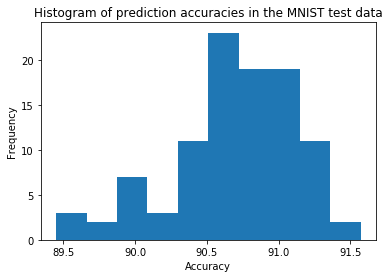

In [10]:
# Compute the accuracy of the model. 
# For each sample we compute the predicted class and compare with the test labels.
# Predicted class is defined as the one which as maximum proability.
# We perform this test for each (w,b) in the posterior giving us a set of accuracies
# Finally we make a histogram of accuracies for the test data.
accy_test = []
for prob in prob_lst:
    y_trn_prd = np.argmax(prob, axis=1).astype(np.float32)
    acc = (y_trn_prd == np.argmax(y_test, axis=1)).mean()*100
    accy_test.append(acc)

plt.hist(accy_test)
plt.title("Histogram of prediction accuracies in the MNIST test data")
plt.xlabel("Accuracy")
plt.ylabel("Frequency")
plt.show()

In [11]:
np.argmax(y_test, axis=1)

array([7, 2, 1, ..., 4, 5, 6])

In [19]:
np.argmax(prob_lst[0], axis=1)

array([7, 2, 1, ..., 4, 5, 6])

In [20]:
# Here we compute the mean of probabilties for each class for all the (w,b) samples.
# We then use the class with maximum of the mean proabilities as the prediction. 
# In other words, we have used (w,b) samples to construct a set of models and
# used their combined outputs to make the predcitions.
Y_pred = np.argmax(np.mean(prob_lst, axis=0), axis=1)
print("Accuracy in predicting the test data = ", (Y_pred == np.argmax(y_test, axis=1)).mean()*100)

Accuracy in predicting the test data =  92.35


Truth =  [ 0.  0.  0.  0.  0.  0.  0.  1.  0.  0.]


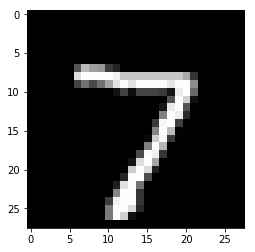

In [21]:
# Load the first image from the test data and its label.
from scipy.misc import toimage
test_image = x_test[0:1]
test_label = y_test[0]
print('Truth = ',test_label)
pixels = test_image.reshape((28,28))
plt.imshow(pixels, cmap = 'gray')
plt.show()

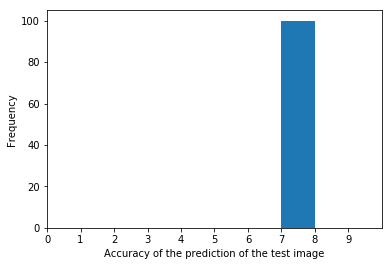

In [22]:
sing_img_probs = []
for w_samp, b_samp in zip(w_samples, b_samples):
    prob = tf.nn.softmax(tf.matmul(x_test[0:1], w_samp ) + b_samp)
    sing_img_probs.append(prob.eval())
# Create a histogram of these predictions.
plt.hist(np.argmax(sing_img_probs, axis=2),bins=range(10))
plt.xticks(np.arange(0,10))
plt.xlim(0,10)
plt.xlabel("Accuracy of the prediction of the test image")
plt.ylabel("Frequency")
plt.show()

### Bayesian Neural Network CIFAR10 Image Recognition

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf
from edward.models import Categorical, Normal
import edward as ed
import pandas as pd

In [2]:
#from observations import cifar10
#(x_train, y_train), (x_test, y_test) = cifar10("~/data")
#x_train = x_train.astype('float32')
#x_test = x_test.astype('float32')
#x_train = x_train / 255.0
#x_test = x_test / 255.0
#print(x_train.shape)
#print(x_test.shape)

Using TensorFlow backend.


(60000, 28, 28)
(10000, 28, 28)


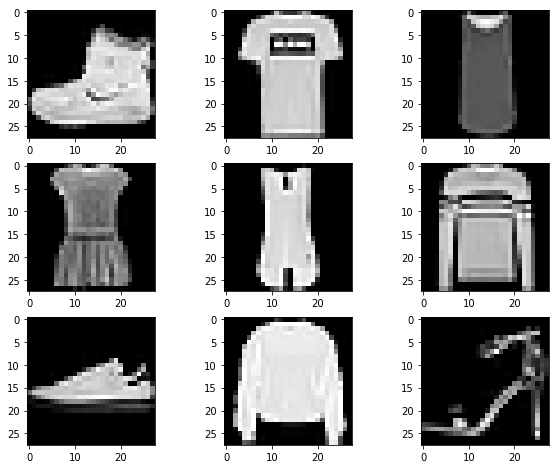

In [3]:
# Plot ad hoc CIFAR10 instances
from keras.datasets import cifar10
from keras.datasets import fashion_mnist
from matplotlib import pyplot
from scipy.misc import toimage

#(x_train, y_train), (x_test, y_test) = cifar10.load_data()
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train = x_train / 255.0
x_test = x_test / 255.0
#x_train = x_train.reshape(x_train.shape[0],3,32,32)
#x_test = x_test.reshape(x_test.shape[0],3,32,32)
print(x_train.shape)
print(x_test.shape)
plt.figure(figsize=(10,8))
for i in range(0, 9):
    pyplot.subplot(330 + 1 + i)
    #pyplot.imshow(toimage(x_train[i].reshape(32,32,3)))
    pyplot.imshow(toimage(x_train[i]))
pyplot.show()

In [4]:
init_dim = x_test.shape[1]
print(init_dim)

28


In [5]:
#import matplotlib.pyplot as plt

#img = 0
#plt.figure(figsize=(4, 2))
#plt.subplot(1, 2, 1)
#plt.imshow(x_test[img], interpolation='none')

#def grayscale(data, dtype='float32'):
    # luma coding weighted average in video systems
#    r, g, b = np.asarray(.3, dtype=dtype), np.asarray(.59, dtype=dtype), np.asarray(.11, dtype=dtype)
#    rst = r * data[:, :, :, 0] + g * data[:, :, :, 1] + b * data[:, :, :, 2]
    # add channel dimension
#    rst = np.expand_dims(rst, axis=3)
#    return rst

#x_train = grayscale(x_train)
#x_test = grayscale(x_test)

# plot a randomly chosen image
#plt.subplot(1, 2, 2)
#plt.imshow(x_test[img, :, :, 0], cmap = 'gray', interpolation='none')
#plt.show()

In [6]:
print(x_train.shape)
print(x_test.shape)

(60000, 28, 28)
(10000, 28, 28)


In [7]:
D = x_train.shape[1]*x_train.shape[1]
print(D)

784


In [8]:
x_train = x_train.reshape((x_train.shape[0],D))
x_test = x_test.reshape((x_test.shape[0],D))
print(x_train.shape)
print(x_test.shape)

(60000, 784)
(10000, 784)


In [9]:
from keras.utils import to_categorical
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
print(y_train.shape)
print(y_test.shape)

(60000, 10)
(10000, 10)


In [10]:
ed.set_seed(314159)
N = 100    # number of images in a minibatch.
D = D      # number of features.
K = 10     # number of classes.

# Create a placeholder to hold the data (in minibatches) in a TensorFlow graph.
x = tf.placeholder(tf.float32, [None, D])
# Normal(0,1) priors for the variables. Note that the syntax assumes TensorFlow 1.1.
w = Normal(loc=tf.zeros([D, K]), scale=tf.ones([D, K]))
b = Normal(loc=tf.zeros(K), scale=tf.ones(K))
# Categorical likelihood for classication.
y = Categorical(tf.matmul(x, w) + b)

In [11]:
# Contruct the q(w) and q(b). in this case we assume Normal distributions.
qw = Normal(loc=tf.Variable(tf.random_normal([D, K])),
              scale=tf.nn.softplus(tf.Variable(tf.random_normal([D, K]))))
qb = Normal(loc=tf.Variable(tf.random_normal([K])),
              scale=tf.nn.softplus(tf.Variable(tf.random_normal([K]))))

In [12]:
def generator(arrays, batch_size = N):
    starts = [0] * len(arrays)  # pointers to where we are in iteration
    while True:
        batches = []
        for i, array in enumerate(arrays):
            start = starts[i]
            stop = start + batch_size
            diff = stop - array.shape[0]
            if diff <= 0:
                batch = array[start:stop]
                starts[i] += batch_size
            else:
                batch = np.concatenate((array[start:], array[:diff]))
                starts[i] = diff
            batches.append(batch)
        yield batches
cifar10 = generator([x_train, y_train], N)

In [13]:
# We use a placeholder for the labels in anticipation of the traning data.
y_ph = tf.placeholder(tf.int32, [N])
# Define the VI inference technique, ie. minimise the KL divergence between q and p.
inference = ed.KLqp({w: qw, b: qb}, data={y: y_ph})
# Initialse the infernce variables
inference.initialize(n_iter=50000, n_print=100, scale={y: float(x_train.shape[0]) / N})
# We will use an interactive session.
sess = tf.InteractiveSession()
# Initialise all the vairables in the session.
tf.global_variables_initializer().run()
# Let the training begin. We load the data in minibatches and update the VI infernce using each new batch.
for _ in range(inference.n_iter):
    X_batch, Y_batch = next(cifar10)
    #X_batch = X_batch.reshape(N,-1)
    # TensorFlow method gives the label data in a one hot vetor format. We convert that into a single label.
    Y_batch = np.argmax(Y_batch, axis=1)
    info_dict = inference.update(feed_dict={x: X_batch, y_ph: Y_batch})
    inference.print_progress(info_dict)

50000/50000 [100%] ██████████████████████████████ Elapsed: 221s | Loss: 85453.266


In [14]:
# Generate samples the posterior and store them.
n_samples = 100
prob_lst = []
samples = []
w_samples = []
b_samples = []
for _ in range(n_samples):
    w_samp = qw.sample()
    b_samp = qb.sample()
    w_samples.append(w_samp)
    b_samples.append(b_samp)
    # Also compute the probabiliy of each class for each (w,b) sample.
    prob = tf.nn.softmax(tf.matmul(x_test, w_samp) + b_samp)
    prob_lst.append(prob.eval())
    sample = tf.concat([tf.reshape(w_samp,[-1]),b_samp],0)
    samples.append(sample.eval())

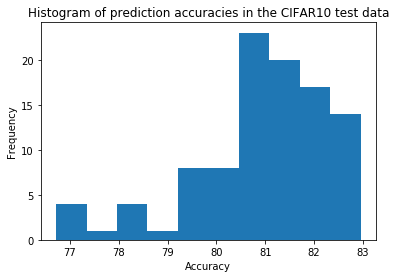

In [15]:
# Compute the accuracy of the model. 
# For each sample we compute the predicted class and compare with the test labels.
# Predicted class is defined as the one which as maximum probability.
# We perform this test for each (w,b) in the posterior giving us a set of accuracies
# Finally we make a histogram of accuracies for the test data.
accy_test = []
for prob in prob_lst:
    y_trn_prd = np.argmax(prob, axis=1).astype(np.float32)
    acc = (y_trn_prd == np.argmax(y_test, axis=1)).mean()*100
    accy_test.append(acc)

plt.hist(accy_test)
plt.title("Histogram of prediction accuracies in the CIFAR10 test data")
plt.xlabel("Accuracy")
plt.ylabel("Frequency")
plt.show()

In [16]:
# Here we compute the mean of probabilties for each class for all the (w,b) samples.
# We then use the class with maximum of the mean proabilities as the prediction. 
# In other words, we have used (w,b) samples to construct a set of models and
# used their combined outputs to make the predcitions.
Y_pred = np.argmax(np.mean(prob_lst, axis=0), axis=1)
print("Accuracy in predicting the test data = ", (Y_pred == np.argmax(y_test, axis=1)).mean()*100)

Accuracy in predicting the test data =  83.77


Truth =  [ 0.  0.  1.  0.  0.  0.  0.  0.  0.  0.]


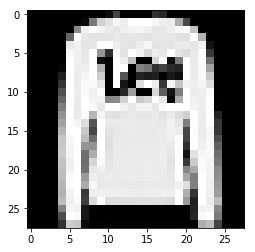

In [17]:
# Load the first image from the test data and its label.
from scipy.misc import toimage
test_image = x_test[1:2]
test_label = y_test[1]
print('Truth = ',test_label)
pixels = test_image.reshape((init_dim, init_dim))
plt.imshow(pixels, cmap = 'gray')
plt.show()

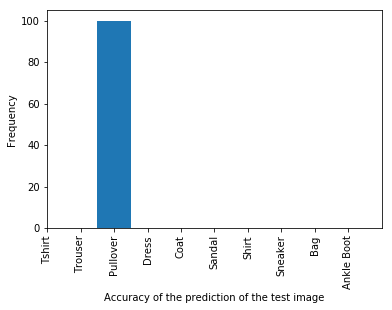

In [18]:
sing_img_probs = []
for w_samp, b_samp in zip(w_samples, b_samples):
    prob = tf.nn.softmax(tf.matmul(x_test[1:2], w_samp ) + b_samp)
    sing_img_probs.append(prob.eval())
# Create a histogram of these predictions.
plt.hist(np.argmax(sing_img_probs, axis=2),bins=range(10), histtype='bar', align='left')
plt.xticks(np.arange(0,10), ['Tshirt', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt',
                             'Sneaker', 'Bag', 'Ankle Boot'], rotation='vertical')
plt.xlim(0,10)
plt.xlabel("Accuracy of the prediction of the test image")
plt.ylabel("Frequency")
plt.show()

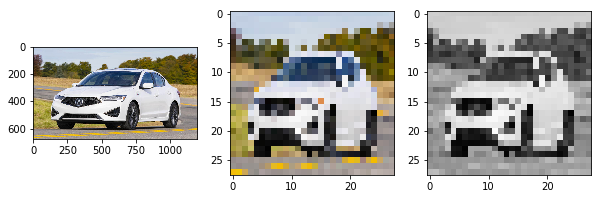

In [19]:
from PIL import Image
plt.figure(figsize=(10,8))
img = Image.open('/home/nikolay/Documents/car.jpeg')
plt.subplot(131)
plt.imshow(img)
plt.subplot(132)
img = img.resize((init_dim,init_dim))
plt.imshow(img)
plt.subplot(133)
img = img.convert(mode='L')
plt.imshow(img)
plt.show()

In [20]:
x_test[1:2].shape

(1, 784)

In [21]:
from numpy import asarray
asarray(img).reshape(1,-1).shape

(1, 784)

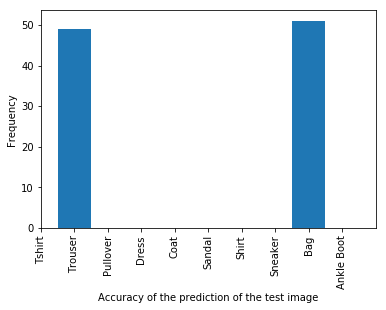

In [23]:
sing_img_probs = []
for w_samp, b_samp in zip(w_samples, b_samples):
    prob = tf.nn.softmax(tf.matmul(np.array(asarray(img).reshape(1,-1),dtype="float32"), w_samp ) + b_samp)
    sing_img_probs.append(prob.eval())
# Create a histogram of these predictions.
plt.hist(np.argmax(sing_img_probs, axis=2), bins=range(10), histtype='bar', align='left')
plt.xticks(np.arange(0,10), ['Tshirt', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt',
                             'Sneaker', 'Bag', 'Ankle Boot'], rotation='vertical')
plt.xlim(0,10)
plt.xlabel("Accuracy of the prediction of the test image")
plt.ylabel("Frequency")
plt.show()

### Frequentist Convolutional Neural Network Fasion MNIST Image Recognition

(60000, 28, 28)
(10000, 28, 28)


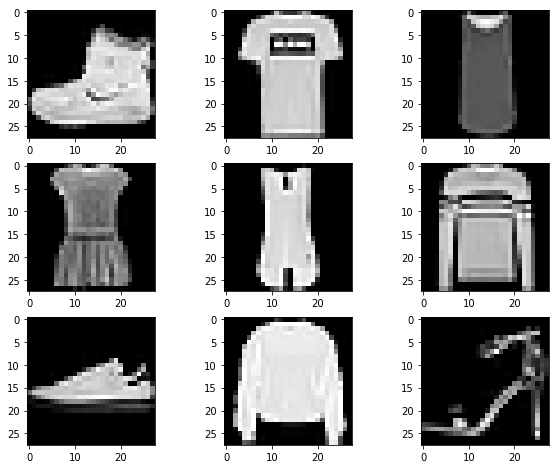

In [23]:
import numpy
from keras.datasets import fashion_mnist
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.constraints import maxnorm
from keras.optimizers import SGD
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.utils import np_utils
from keras import backend as K
K.set_image_dim_ordering('th')
import matplotlib.pyplot as plt
from scipy.misc import toimage
# fix random seed for reproducibility
seed = 7
numpy.random.seed(seed)
# load data
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()
print(X_train.shape)
print(X_test.shape)
plt.figure(figsize=(10,8))
for i in range(0, 9):
    plt.subplot(330 + 1 + i)
    #plt.imshow(toimage(x_train[i].reshape(32,32,3)))
    plt.imshow(toimage(X_train[i]))
plt.show()

In [24]:
# normalize inputs from 0-255 to 0.0-1.0
X_train = X_train.reshape(X_train.shape[0], 1, 28, 28).astype('float32')
X_test = X_test.reshape(X_test.shape[0], 1, 28, 28).astype('float32')
X_train = X_train / 255.0
X_test = X_test / 255.0

In [25]:
# one hot encode outputs
y_train = np_utils.to_categorical(y_train)
y_test = np_utils.to_categorical(y_test)
num_classes = y_test.shape[1]
print(num_classes)

10


In [27]:
# Create the model
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=(1, 28, 28), padding='same', activation='relu',
                 kernel_constraint=maxnorm(3)))
model.add(Dropout(0.2))
model.add(Conv2D(32, (3, 3), padding='same', activation='relu',
                 kernel_constraint=maxnorm(3)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(512, activation='relu', kernel_constraint=maxnorm(3)))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

# Compile model
epochs = 25
lrate = 0.01
decay = lrate/epochs
sgd = SGD(lr=lrate, momentum=0.9, decay=decay, nesterov=False)
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 32, 28, 28)        320       
_________________________________________________________________
dropout_7 (Dropout)          (None, 32, 28, 28)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 32, 28, 28)        9248      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 32, 14, 14)        0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 6272)              0         
_________________________________________________________________
dense_7 (Dense)              (None, 512)               3211776   
_________________________________________________________________
dropout_8 (Dropout)          (None, 512)               0         
__________

In [28]:
# Fit the model
#model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=epochs, batch_size=32)
history = model.fit(X_train, y_train, epochs = epochs, verbose = 1, validation_split = 0.25,
                   batch_size = 32, shuffle = True)

Train on 45000 samples, validate on 15000 samples
Epoch 1/25
45000/45000 [==============================] - 1158s 26ms/step - loss: 0.5762 - acc: 0.7917 - val_loss: 0.3973 - val_acc: 0.8542
Epoch 2/25
45000/45000 [==============================] - 1124s 25ms/step - loss: 0.3643 - acc: 0.8676 - val_loss: 0.3127 - val_acc: 0.8841
Epoch 3/25
45000/45000 [==============================] - 1158s 26ms/step - loss: 0.3129 - acc: 0.8853 - val_loss: 0.2825 - val_acc: 0.8956
Epoch 4/25
45000/45000 [==============================] - 1609s 36ms/step - loss: 0.2813 - acc: 0.8973 - val_loss: 0.2727 - val_acc: 0.9005
Epoch 5/25
45000/45000 [==============================] - 902s 20ms/step - loss: 0.2618 - acc: 0.9048 - val_loss: 0.2588 - val_acc: 0.9045
Epoch 6/25
45000/45000 [==============================] - 936s 21ms/step - loss: 0.2451 - acc: 0.9098 - val_loss: 0.2564 - val_acc: 0.9035
Epoch 7/25
45000/45000 [==============================] - 945s 21ms/step - loss: 0.2323 - acc: 0.9154 - val_loss

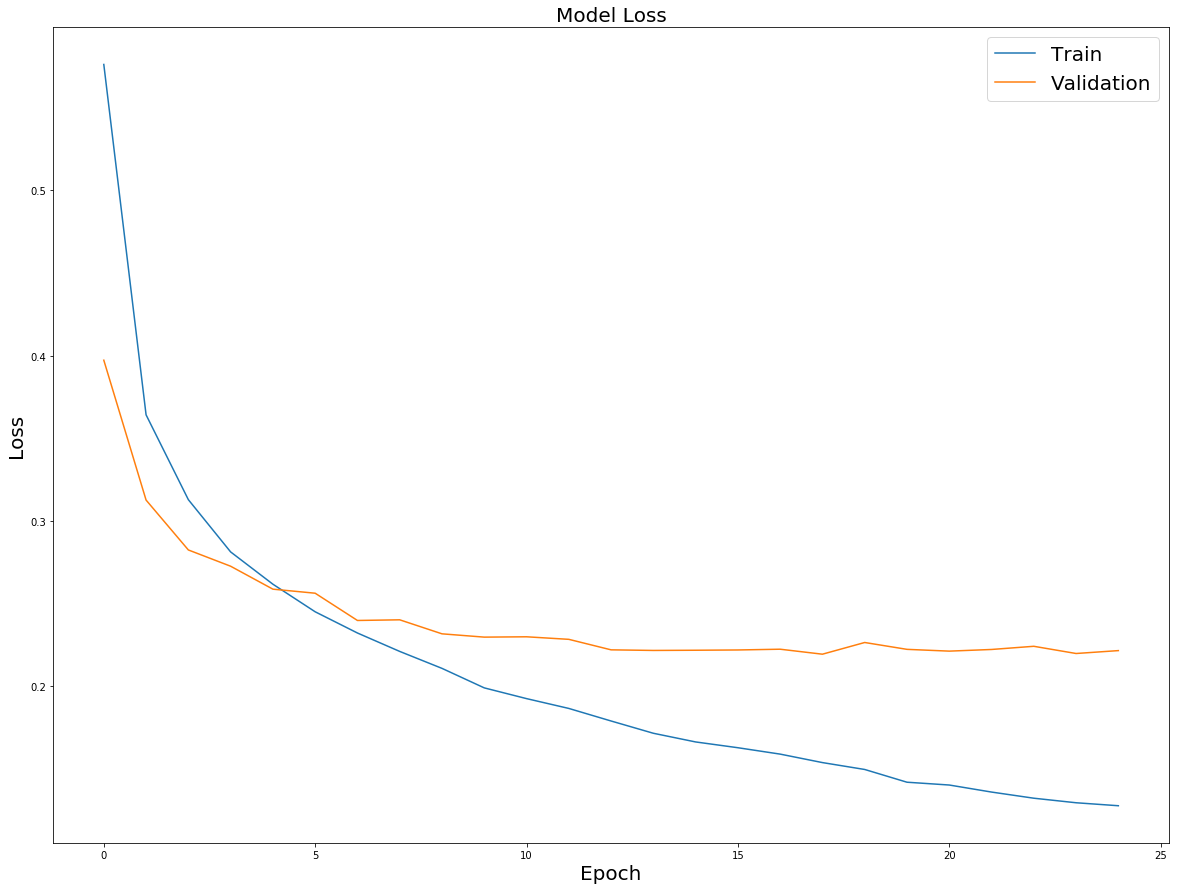

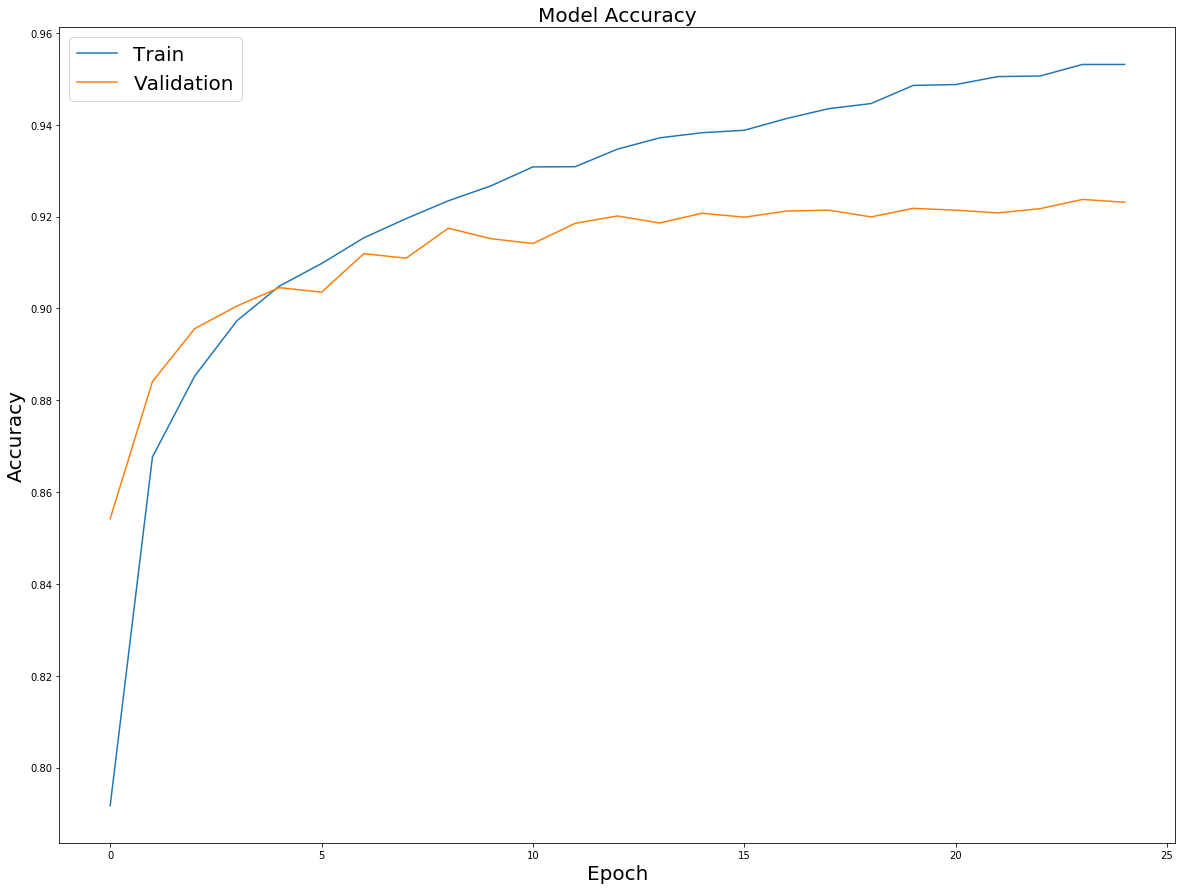

In [29]:
plt.figure(figsize=(20,15))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss', fontsize = 20)
plt.ylabel('Loss', fontsize = 20)
plt.xlabel('Epoch', fontsize = 20)
plt.legend(['Train', 'Validation'], fontsize = 20)
plt.show()

plt.figure(figsize=(20,15))
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model Accuracy', fontsize = 20)
plt.ylabel('Accuracy', fontsize = 20)
plt.xlabel('Epoch', fontsize = 20)
plt.legend(['Train', 'Validation'], fontsize = 20)
plt.show()

In [30]:
scores = model.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Accuracy: 91.41%


Truth =  [ 0.  0.  1.  0.  0.  0.  0.  0.  0.  0.]


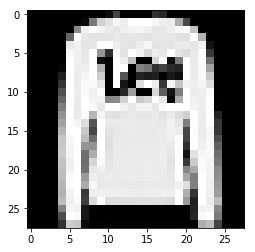

In [31]:
# Load the first image from the test data and its label.
from scipy.misc import toimage
test_image = X_test[1:2]
test_label = y_test[1]
print('Truth = ',test_label)
pixels = test_image.reshape((28, 28))
plt.imshow(pixels, cmap = 'gray')
plt.show()

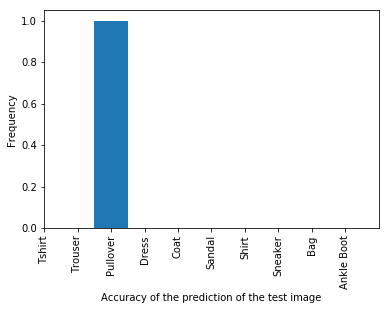

In [70]:
import numpy as np
plt.hist(np.argmax(model.predict(X_test[1:2])), bins=range(10), histtype='bar', align='left')
plt.xticks(np.arange(0,10), ['Tshirt', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt',
                             'Sneaker', 'Bag', 'Ankle Boot'], rotation='vertical')
plt.xlim(0,10)
plt.xlabel("Accuracy of the prediction of the test image")
plt.ylabel("Frequency")
plt.show()

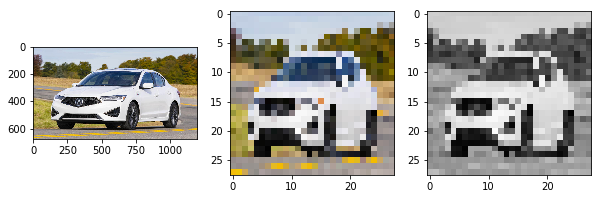

In [44]:
from PIL import Image
plt.figure(figsize=(10,8))
img = Image.open('/home/nikolay/Documents/car.jpeg')
plt.subplot(131)
plt.imshow(img)
plt.subplot(132)
img = img.resize((28,28))
plt.imshow(img)
plt.subplot(133)
img = img.convert(mode='L')
plt.imshow(img)
plt.show()

In [50]:
X_test[1:2].shape

(1, 1, 28, 28)

In [57]:
from numpy import asarray
np.expand_dims(np.expand_dims(np.array(asarray(img),dtype="float32"),axis=0),axis=0).shape

(1, 1, 28, 28)

In [58]:
model.predict(np.expand_dims(np.expand_dims(np.array(asarray(img),dtype="float32"),axis=0),axis=0))

array([[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.]], dtype=float32)

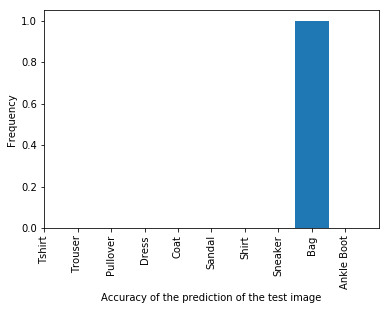

In [68]:
import numpy as np
plt.hist(np.argmax(model.predict(np.expand_dims(np.expand_dims(np.array(asarray(img),
                                                                        dtype="float32"),axis=0),axis=0))), 
         bins=range(10), histtype='bar', align='left')
plt.xticks(np.arange(0,10), ['Tshirt', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt',
                             'Sneaker', 'Bag', 'Ankle Boot'], rotation='vertical')
plt.xlim(0,10)
plt.xlabel("Accuracy of the prediction of the test image")
plt.ylabel("Frequency")
plt.show()

### Bayesian Neural Network CIFAR10 Image Recognition with Hidden Layers

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf
from edward.models import Categorical, Normal
import edward as ed
import pandas as pd

Using TensorFlow backend.


(60000, 28, 28)
(10000, 28, 28)


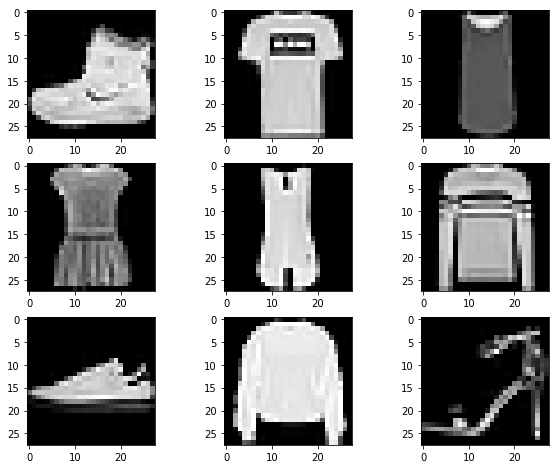

In [2]:
# Plot ad hoc CIFAR10 instances
from keras.datasets import cifar10
from keras.datasets import fashion_mnist
from matplotlib import pyplot
from scipy.misc import toimage

#(x_train, y_train), (x_test, y_test) = cifar10.load_data()
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train = x_train / 255.0
x_test = x_test / 255.0
#x_train = x_train.reshape(x_train.shape[0],3,32,32)
#x_test = x_test.reshape(x_test.shape[0],3,32,32)
print(x_train.shape)
print(x_test.shape)
plt.figure(figsize=(10,8))
for i in range(0, 9):
    pyplot.subplot(330 + 1 + i)
    #pyplot.imshow(toimage(x_train[i].reshape(32,32,3)))
    pyplot.imshow(toimage(x_train[i]))
pyplot.show()

In [3]:
init_dim = x_test.shape[1]
print(init_dim)

28


In [4]:
D = x_train.shape[1]*x_train.shape[1]
print(D)

784


In [5]:
x_train = x_train.reshape((x_train.shape[0],D))
x_test = x_test.reshape((x_test.shape[0],D))
print(x_train.shape)
print(x_test.shape)

(60000, 784)
(10000, 784)


In [6]:
from keras.utils import to_categorical
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
print(y_train.shape)
print(y_test.shape)

(60000, 10)
(10000, 10)


In [7]:
ed.set_seed(314159)
N = 100   # number of images in a minibatch.
D = D     # number of features.
K = 10    # number of classes.

n_samples = N                 # number of samples, equal N
n_input = D                   # number of input neurons
n_hidden = 16
n_classes = K

W_0 = Normal(loc=tf.zeros([n_input, n_hidden]), scale=tf.ones([n_input, n_hidden]))
W_1 = Normal(loc=tf.zeros([n_hidden, n_classes]), scale=tf.ones([n_hidden, n_classes]))
b_0 = Normal(loc=tf.zeros(n_hidden), scale=tf.ones(n_hidden))
b_1 = Normal(loc=tf.zeros(n_classes), scale=tf.ones(n_classes))


# Create a placeholder to hold the data (in minibatches) in a TensorFlow graph.
x = tf.placeholder(tf.float32, [None, D])
# Normal(0,1) priors for the variables. Note that the syntax assumes TensorFlow 1.1.
#w = Normal(loc=tf.zeros([D, K]), scale=tf.ones([D, K]))
#b = Normal(loc=tf.zeros(K), scale=tf.ones(K))
# Categorical likelihood for classication.
#y = Categorical(tf.matmul(x, w) + b)
y = Categorical(tf.matmul(tf.sigmoid(tf.matmul(x, W_0) + b_0), W_1) + b_1)

In [8]:
# Contruct the q(w) and q(b). in this case we assume Normal distributions.
#qw = Normal(loc=tf.Variable(tf.random_normal([D, K])),
#              scale=tf.nn.softplus(tf.Variable(tf.random_normal([D, K]))))
#qb = Normal(loc=tf.Variable(tf.random_normal([K])),
#              scale=tf.nn.softplus(tf.Variable(tf.random_normal([K]))))

qW_0 = Normal(loc=tf.get_variable("qW_0/loc1", [n_input, n_hidden]), 
              scale=tf.nn.softplus(tf.get_variable("qW_0/sc1", [n_input, n_hidden])))
qW_1 = Normal(loc=tf.get_variable("qW_1/loc1", [n_hidden, n_classes]), 
              scale=tf.nn.softplus(tf.get_variable("qW_1/sc1", [n_hidden, n_classes])))
qb_0 = Normal(loc=tf.get_variable("qb_0/loc1", [n_hidden]), 
              scale=tf.nn.softplus(tf.get_variable("qb_0/sc1", [n_hidden])))
qb_1 = Normal(loc=tf.get_variable("qb_1/loc1", [n_classes]), 
              scale=tf.nn.softplus(tf.get_variable("qb_1/sc1", [n_classes])))

In [9]:
def generator(arrays, batch_size = N):
    starts = [0] * len(arrays)  # pointers to where we are in iteration
    while True:
        batches = []
        for i, array in enumerate(arrays):
            start = starts[i]
            stop = start + batch_size
            diff = stop - array.shape[0]
            if diff <= 0:
                batch = array[start:stop]
                starts[i] += batch_size
            else:
                batch = np.concatenate((array[start:], array[:diff]))
                starts[i] = diff
            batches.append(batch)
        yield batches
cifar10 = generator([x_train, y_train], N)

In [10]:
# We use a placeholder for the labels in anticipation of the traning data.
y_ph = tf.placeholder(tf.int32, [N])
# Define the VI inference technique, ie. minimise the KL divergence between q and p.
inference = ed.KLqp({W_0: qW_0, b_0: qb_0, W_1: qW_1, b_1: qb_1}, data={y: y_ph})
# Initialse the infernce variables
inference.initialize(n_iter=5000, n_print=100, scale={y: float(x_train.shape[0]) / N})
# We will use an interactive session.
sess = tf.InteractiveSession()
# Initialise all the vairables in the session.
tf.global_variables_initializer().run()
# Let the training begin. We load the data in minibatches and update the VI infernce using each new batch.
for _ in range(inference.n_iter):
    X_batch, Y_batch = next(cifar10)
    #X_batch = X_batch.reshape(N,-1)
    # TensorFlow method gives the label data in a one hot vetor format. We convert that into a single label.
    Y_batch = np.argmax(Y_batch, axis=1)
    info_dict = inference.update(feed_dict={x: X_batch, y_ph: Y_batch})
    inference.print_progress(info_dict)

5000/5000 [100%] ██████████████████████████████ Elapsed: 11s | Loss: 53196.828


In [11]:
# Generate samples from the posterior and store them.
n_samples = 20
prob_lst = []
#samples = []
w0_samples = []
b0_samples = []
w1_samples = []
b1_samples = []
for _ in range(n_samples):
    w0_samp = qW_0.sample()
    b0_samp = qb_0.sample()
    w1_samp = qW_1.sample()
    b1_samp = qb_1.sample()
    w0_samples.append(w0_samp)
    b0_samples.append(b0_samp)
    w1_samples.append(w1_samp)
    b1_samples.append(b1_samp)
    # Also compue the probabiliy of each class for each (w,b) sample.
    prob = tf.nn.softmax(tf.matmul(tf.sigmoid(tf.matmul(x_train, W_0) + b_0), W_1) + b_1)
    prob_lst.append(prob.eval())
    #sample = tf.concat([tf.reshape(w_samp,[-1]),b_samp],0)
    #samples.append(sample.eval())

In [12]:
np.argmax(y_test, axis=1)

array([9, 2, 1, ..., 8, 1, 5])

In [13]:
np.argmax(prob_lst[0],axis=1)

array([6, 6, 6, ..., 6, 6, 6])

In [14]:
len(prob_lst)

20

In [15]:
prob_lst[0].shape

(60000, 10)

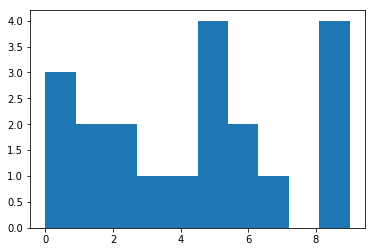

In [16]:
plt.hist([np.argmax(i,axis=1)[0] for i in prob_lst])
plt.show()

In [17]:
lst = [np.argmax(i,axis=1)[0] for i in prob_lst]
max(set(lst), key=lst.count)

5

In [18]:
np.argmax(y_test, axis=1)

array([9, 2, 1, ..., 8, 1, 5])

In [19]:
np.argmax(np.mean(prob_lst, axis=0), axis=1)

array([0, 2, 2, ..., 2, 0, 5])

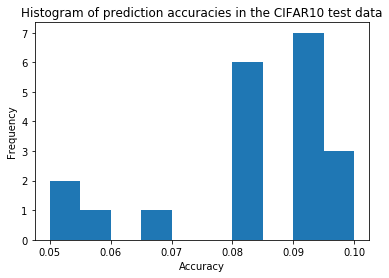

In [20]:
# Compute the accuracy of the model. 
# For each sample we compute the predicted class and compare with the test labels.
# Predicted class is defined as the one which as maximum proability.
# We perform this test for each (w,b) in the posterior giving us a set of accuracies
# Finally we make a histogram of accuracies for the test data.
accy_test = []
for prob in prob_lst:
    y_trn_prd = np.argmax(prob, axis=1).astype(np.float32)
    acc = (len(set(list(np.argmax(y_test, axis=1))) & set(list(np.argmax(prob, axis=1))))
           /len(list(np.argmax(y_test, axis=1))))*100
    accy_test.append(acc)

plt.hist(accy_test)
plt.title("Histogram of prediction accuracies in the CIFAR10 test data")
plt.xlabel("Accuracy")
plt.ylabel("Frequency")
plt.show()

In [21]:
# Here we compute the mean of probabilties for each class for all the (w,b) samples.
# We then use the class with maximum of the mean proabilities as the prediction. 
# In other words, we have used (w,b) samples to construct a set of models and
# used their combined outputs to make the predcitions.
Y_pred = np.argmax(np.mean(prob_lst, axis=0), axis=1)
print("Accuracy in predicting the test data = ", len(set(list(np.argmax(y_test, axis=1))) & set(Y_pred))
           /len(list(np.argmax(y_test, axis=1))))
print(Y_pred)

Accuracy in predicting the test data =  0.0009
[0 2 2 ..., 2 0 5]


In [22]:
sing_img_probs = []
for w_samp, b_samp in zip(w_samples, b_samples):
    prob = tf.nn.softmax(tf.matmul(x_test[0:1], w_samp ) + b_samp)
    sing_img_probs.append(prob.eval())
# Create a histogram of these predictions.
plt.hist(np.argmax(sing_img_probs, axis=2),bins=range(10))
plt.xticks(np.arange(0,10))
plt.xlim(0,10)
plt.xlabel("Accuracy of the prediction of the test image")
plt.ylabel("Frequency")
plt.show()

NameError: name 'w_samples' is not defined

In [21]:
y_test[0]

array([ 0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.])